<a href="https://colab.research.google.com/github/Svenmn/BAN-443/blob/main/StortingetAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Package Import**

In [ ]:
## Import package
import requests
import pandas as pd
from google.colab import userdata
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import io
import json
import logging
import openai
from openai import AzureOpenAI



If you get an error, make sure the packages are installed

To install packages type the following: pip install "name of package"

# **Importing the Data from the Stortinget API**


---



In [ ]:
response = requests.get("https://data.stortinget.no/eksport/sporretimesporsmal?sesjonid=2022-2023") #The API link has a date selector in this case 2022-2023, this can be altered

data = response.text
tree = ET.parse(io.StringIO(data))
root = tree.getroot()



Parsing the data

In [ ]:
# Define the namespace
ns = {'ns': 'http://data.stortinget.no'}

# Extract the <tittel> elements (Questions)
questions = [sporsmal.find('ns:tittel', ns).text for sporsmal in root.findall('.//ns:sporsmal', ns)]

# Extract the <fornavn> and <etternavn> elements from <sporsmal_fra> (Question from)
from_names = [
    f"{sporsmal.find('ns:sporsmal_fra/ns:fornavn', ns).text} {sporsmal.find('ns:sporsmal_fra/ns:etternavn', ns).text}"
    for sporsmal in root.findall('.//ns:sporsmal', ns)
]

# Extract the <navn> element from <parti> (Party)
parties = [
    sporsmal.find('ns:sporsmal_fra/ns:parti/ns:navn', ns).text
    for sporsmal in root.findall('.//ns:sporsmal', ns)
]

# Create a DataFrame with the extracted data
df = pd.DataFrame({
    'Question': questions,
    'Question from': from_names,
    'Party': parties
})





Test to see if code worked

In [ ]:
print(df.head)

<bound method NDFrame.head of                                               Question          Question from  \
0    Det brukes betydelige ressurser på å føre tils...        Hege Bae Nyholt   
1    I februar spurte jeg statsråden om hvorvidt ut...     Sveinung Stensland   
2    Den 21. september 2022 hadde statsråden et uts...            Ingunn Foss   
3    I Hurdalsplattformen sier regjeringen: "Klima ...          Sofie Marhaug   
4    I over 400 dager har Olje- og energidepartemen...          Henrik Asheim   
..                                                 ...                    ...   
515  Det er nå ett år siden Høyesterett avsa en ens...          Ingrid Fiskaa   
516  Det er nå ett år siden Høyesterett avsa en ens...         Kirsti Bergstø   
517  Det er nå ett år siden Høyesterett avsa en ens...       Lars Haltbrekken   
518  Fosen-dommen slo fast at staten braut menneske...  Birgit Oline Kjerstad   
519  Senterpartiet har tidlegare forsøkt å framstå ...       Frank Edvard Sve  

How to refer to spesific Questions

In [ ]:
print(questions[7])

En ny forskningsrapport om transnasjonal undertrykkelse, bestilt av Arbeids- og inkluderingsdepartementet, viser at den norske regjeringen for tiden ikke prioriterer kampen mot transnasjonal undertrykkelse høyt. Rapporten peker på justis- og utenrikssektoren. Vi har altså eritreere, etiopiere, tsjetsjenere, tyrkere og uigurer som ikke lever frie liv i Norge, men blir utsatt for press og kontroll fra hjemlandet. Eritreere i Norge blir for eksempel pålagt å betale to prosent skatt til Eritrea. Innkrevingskontoret ligger i Karl Johans gate. 
Hvordan vil regjeringen beskytte norske innbyggere mot transnasjonal undertrykkelse?


Need to add:

---


*   Change the API URL to relevent time horizon, right now it is 2022-2023.
  *   Useful dataset could be between 1000 - 10000 rows maybe?
*   Create connection to OpenAI API
*   Loop for all the questions to feed into OpenAI API
*   Give OpenAI promts to extract or interpret from the questions, this could be:
  *   Topic: Economy, Military, Culture ect
  *   Sentiment: Positive, Negative ect maybe a scale 1-10 or 0-1









# **Code for OpenAI API**

---



Initial Setup: **You might need to change the names of the secret keys for this to run**

In [ ]:
client = AzureOpenAI(
  azure_endpoint = "https://gpt-api-education.openai.azure.com/",
  api_key=userdata.get("AZURE_OPENAI_API_KEY"),
  api_version="2024-02-15-preview"
)

Creating subset for testing purposes **Change the .head(n) for smaller/larger subset, remove for the entire dataset**

In [ ]:
subset_questions = df['Question'].head(50)

Defining system and user promts. **Update this with desired prompts**

In [ ]:
# Define the system prompt
system_prompt = "You are a political analyst, asked to gather insights from questions asked by parliament members."

# Define user prompt templates for different analyses
user_prompts = {
    'topic_classification': """
{question}

Classify the previous question by the topic of discussion.

Possible topics could include: Economy, Culture, Education, Energy, Defence, Climate, etc.

Please provide only the topic.

Only use more than one topic if absolutly necessary, however if more than one topic is applicable, please provide them in a comma-separated list.

An example could be:

Question:

Forsvarskommisjonen av 2021 – Forsvar for fred og frihet foreslår forsvarskommisjonen tre løft for å møte sikkerhetssituasjonen de neste 10–20 årene.
Under overskriften "Løft 1 – kritiske tiltak for å styrke egenevnen" nevnes behovet for rask oppgradering av luftvern og utdanningskapasitet.
Under løft 2 og 3 nevnes behov for mer personell i hele Forsvaret, en større hær og lagdelt, inkludert langtrekkende,
luftvernbeskyttelse rundt blant annet Oslo, Bergen og Trondheim. Hvordan vil statsråden følge opp disse anbefalingene?

Response:

Defence
""",
    'sentiment_analysis': """
{question}

Classify the sentiment of the previous question on a scale from 1 to 10, with 1 being very negative, 5 being neutral, and 10 being very positive.

Provide only the numerical score.
"""
}


Define Analysis Types. **Update this with the names of the desired prompts**

In [ ]:
# Define the analysis types you want to perform
analysis_types = ['topic_classification', 'sentiment_analysis']


Define Parameters for the API request. **Update this if needed**

In [ ]:
# Define the default API parameters
api_params = {
    'temperature': 0.1,
    'max_tokens': 100,
    'top_p': 1,
    'stream': False,
    'stop': None,
}


Reusable Function for API calls

In [ ]:
def analyze_question(question, analysis_type):
    # Select the appropriate user prompt template
    user_prompt = user_prompts[analysis_type].format(question=question)

    # Prepare the request body
    request_body = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        },
    ]

    # Call the OpenAI API
    try:
        response = client.chat.completions.create(
            model="GPT4-API",
            messages=request_body,
            **api_params
        )

        # Extract the content from the response
        result = response.choices[0].message.content.strip()
        return result
    except Exception as e:
        print(f"Error analyzing question: {e}")
        return None


Loop for API calls. Depending on the size of the subsample **This can take a while**

In [ ]:
# Initialize a dictionary to store results
results = {analysis_type: [] for analysis_type in analysis_types}

# Loop through each question with its index
for idx, question in subset_questions.items():
    # Dictionary to hold results for the current question
    analysis_results = {}

    # Perform each analysis
    for analysis_type in analysis_types:
        # Perform analysis
        result = analyze_question(question, analysis_type)

        # Store the result
        analysis_results[analysis_type] = result

    # Assign results to the DataFrame
    for analysis_type, result in analysis_results.items():
        df.at[idx, analysis_type] = result


<ipython-input-42-6daed2891519>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, analysis_type] = result


In [ ]:
print(df.loc[subset_questions.index])

                                             Question  \
0   Det brukes betydelige ressurser på å føre tils...   
1   I februar spurte jeg statsråden om hvorvidt ut...   
2   Den 21. september 2022 hadde statsråden et uts...   
3   I Hurdalsplattformen sier regjeringen: "Klima ...   
4   I over 400 dager har Olje- og energidepartemen...   
5   Et regjeringsnedsatt utvalg skal vurdere om po...   
6   Statsminister Jonas Gahr Støre deltok 16. mai ...   
7   En ny forskningsrapport om transnasjonal under...   
8    En god skole er det viktigste  vi som samfunn...   
9    I budsjettet i høst  kom regjeringen med stor...   
10   Noreg har ein forpliktande  klimaavtale med E...   
11   Jeg vil begynne med å  gratulere statsministe...   
12   Sist helg hadde Arbeiderpartiet  landsmøte. J...   
13   Siden statsministeren tiltrådte,  har behandl...   
14   I morgen kommer revidert nasjonalbudsjett,  o...   
15  I NOU 2023: 14 Forsvarskommisjonen av 2021 – F...   
16  Stortinget har vedtatt å in

#  **Plotting some data**

---



In [ ]:
df['sentiment_analysis'] = pd.to_numeric(df['sentiment_analysis'], errors='coerce')

In [ ]:
# Group by 'Party' and calculate the mean sentiment score
mean_sentiment_by_party = df.groupby('Party')['sentiment_analysis'].mean().reset_index()

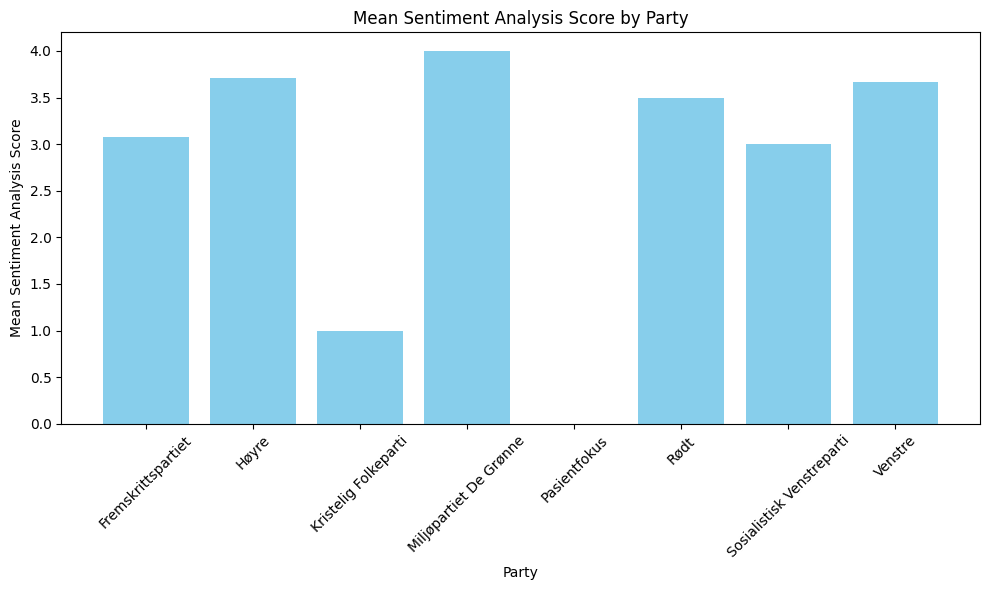

In [ ]:
# Set the size of the plot (optional)
plt.figure(figsize=(10, 6))

# Create the bar chart
plt.bar(mean_sentiment_by_party['Party'], mean_sentiment_by_party['sentiment_analysis'], color='skyblue')

# Add labels and title
plt.xlabel('Party')
plt.ylabel('Mean Sentiment Analysis Score')
plt.title('Mean Sentiment Analysis Score by Party')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

We see here that every single party has a negativity bias. Perhaps we need to look more into our data source

In [ ]:
subset_indices = subset_questions.index
subset_df = df.loc[subset_indices]

subset_df['topic_list'] = subset_df['topic_classification'].str.split(',')
subset_df_exploded = subset_df.explode('topic_list')
subset_df_exploded['topic_list'] = subset_df_exploded['topic_list'].str.strip()
subset_df_exploded = subset_df_exploded.dropna(subset=['topic_list'])

# Get unique topics in the subset
unique_topics_subset = subset_df_exploded['topic_list'].unique()
print("Unique topics in the subset:")
print(unique_topics_subset)

# Get counts of each topic in the subset
topic_counts_subset = subset_df_exploded['topic_list'].value_counts()
print("\nTopic counts in the subset:")
print(topic_counts_subset)

Unique topics in the subset:
['Education' 'Defence' 'Justice' 'Safety' 'Climate' 'Energy' 'Economy'
 'Law & Order' 'Drugs Policy' 'Democracy' 'Human Rights'
 'International Relations' 'Foreign Affairs' 'Healthcare'
 'Social Services' 'Social Policy' 'Mental Health' 'Foreign Aid'
 'Environment' 'Health' 'Agriculture']

Topic counts in the subset:
topic_list
Economy                    25
Education                   7
Energy                      7
Healthcare                  5
Climate                     5
Defence                     3
Human Rights                3
Social Services             2
Environment                 2
Health                      2
Agriculture                 2
Law & Order                 1
Drugs Policy                1
Democracy                   1
Safety                      1
International Relations     1
Foreign Affairs             1
Justice                     1
Social Policy               1
Mental Health               1
Foreign Aid                 1
Name: count

We can see that some of the topics are the same but spelled or worded differently, for example "Law & Order" and "Law and Order". Need to refine this somehow, maybe sending it again through chatgpt to group similar topics.
